In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi yükle
df = pd.read_csv("veri.csv")

# İlk 5 satırı göster
print(df.head())

# Temel istatistikler
print(df.describe())

# Eksik değer kontrolü
print(df.isnull().sum())

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4
       total_bill         tip        size
count  244.000000  244.000000  244.000000
mean    19.785943    2.998279    2.569672
std      8.902412    1.383638    0.951100
min      3.070000    1.000000    1.000000
25%     13.347500    2.000000    2.000000
50%     17.795000    2.900000    2.000000
75%     24.127500    3.562500    3.000000
max     50.810000   10.000000    6.000000
total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64


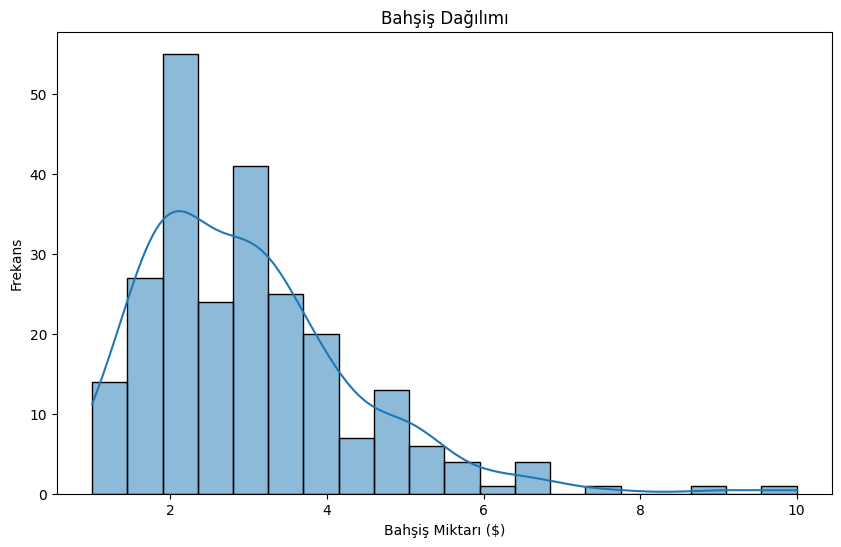

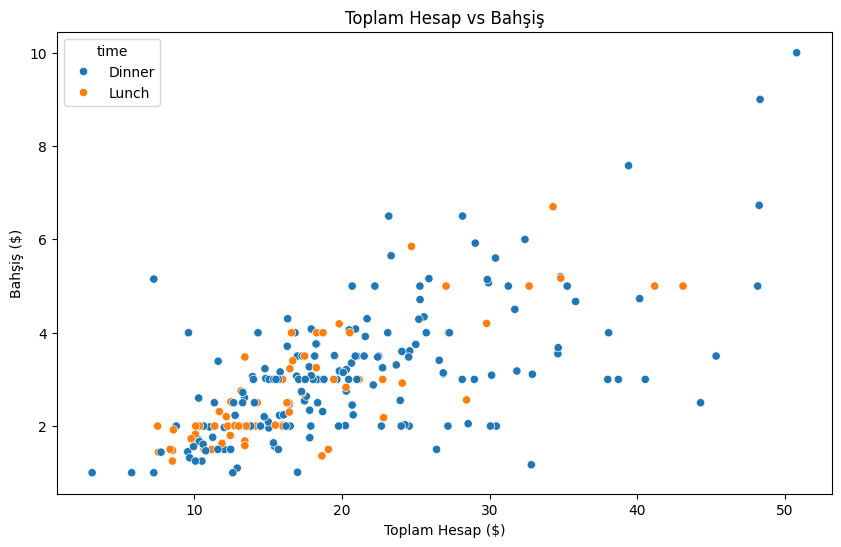

sex
Female    2.833448
Male      3.089618
Name: tip, dtype: float64
smoker
No     2.991854
Yes    3.008710
Name: tip, dtype: float64
day
Fri     2.734737
Sat     2.993103
Sun     3.255132
Thur    2.771452
Name: tip, dtype: float64
time
Dinner    3.102670
Lunch     2.728088
Name: tip, dtype: float64


In [2]:
# Bahşiş dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(df['tip'], kde=True, bins=20)
plt.title('Bahşiş Dağılımı')
plt.xlabel('Bahşiş Miktarı ($)')
plt.ylabel('Frekans')
plt.show()

# Toplam hesap ile bahşiş arasındaki ilişki
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_bill', y='tip', data=df, hue='time')
plt.title('Toplam Hesap vs Bahşiş')
plt.xlabel('Toplam Hesap ($)')
plt.ylabel('Bahşiş ($)')
plt.show()

# Kategorik değişkenlere göre bahşiş ortalamaları
print(df.groupby('sex')['tip'].mean())
print(df.groupby('smoker')['tip'].mean())
print(df.groupby('day')['tip'].mean())
print(df.groupby('time')['tip'].mean())

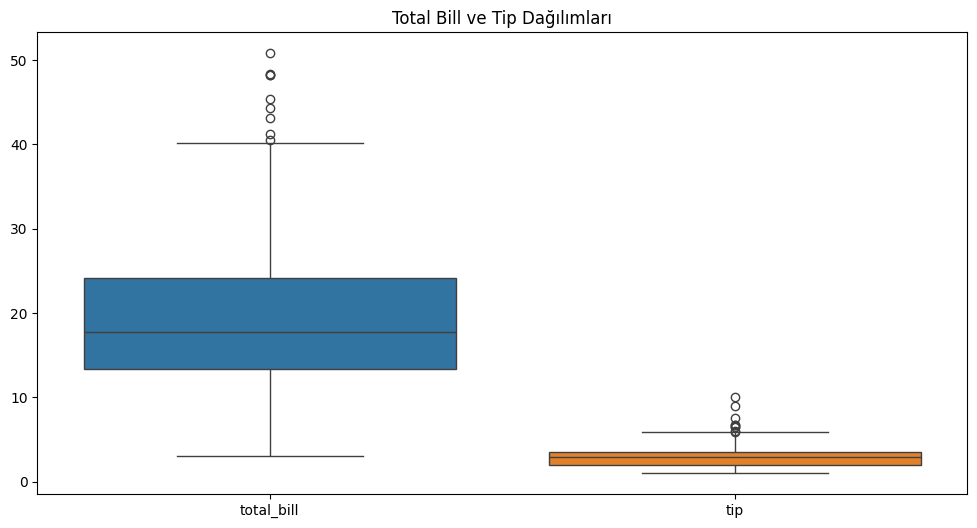

In [3]:
# Boxplot ile aykırı değerlerin tespiti
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['total_bill', 'tip']])
plt.title('Total Bill ve Tip Dağılımları')
plt.show()

# Aykırı değerleri işleme fonksiyonu
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Aykırı değerleri üst ve alt sınırlarla kırpma
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

df = handle_outliers(df, 'total_bill')
df = handle_outliers(df, 'tip')

In [4]:
# Yeni özellikler
df['tip_percentage'] = (df['tip'] / df['total_bill']) * 100  # Bahşiş yüzdesi
df['bill_per_person'] = df['total_bill'] / df['size']  # Kişi başı hesap
df['is_dinner'] = df['time'].apply(lambda x: 1 if x == 'Dinner' else 0)  # Binary zaman

In [5]:
from sklearn.model_selection import train_test_split

# Bağımlı ve bağımsız değişkenler
X = df.drop(['tip', 'tip_percentage'], axis=1)
y = df['tip']

# Train (%70), Validation (%15), Test (%15) bölme
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (170, 8), (170,)
Validation set: (37, 8), (37,)
Test set: (37, 8), (37,)


In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Sayısal ve kategorik değişkenler
numeric_features = ['total_bill', 'size', 'bill_per_person', 'is_dinner']
categorical_features = ['sex', 'smoker', 'day']

# Pipeline oluşturma
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Modeller
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

# Model değerlendirme fonksiyonu
def evaluate_model(model, X_train, y_train, X_val, y_val):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Modelleri değerlendirme
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, y_train, X_val, y_val)
    print(f"{name}: RMSE = {results[name]['RMSE']:.2f}, R2 = {results[name]['R2']:.2f}")

Linear Regression: RMSE = 0.92, R2 = 0.50
Ridge: RMSE = 0.92, R2 = 0.50
Lasso: RMSE = 1.30, R2 = -0.01
Random Forest: RMSE = 0.87, R2 = 0.54
Gradient Boosting: RMSE = 0.96, R2 = 0.45
SVR: RMSE = 0.96, R2 = 0.44


In [8]:
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = models[best_model_name]
print(f"\nEn iyi model: {best_model_name} (RMSE = {results[best_model_name]['RMSE']:.2f})")


En iyi model: Random Forest (RMSE = 0.87)


In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    Pipeline(steps=[('preprocessor', preprocessor),
                   ('model', RandomForestRegressor(random_state=42))]),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train, y_train)
print(f"En iyi parametreler: {grid_search.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
En iyi parametreler: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}


In [10]:
final_model = grid_search.best_estimator_
y_test_pred = final_model.predict(X_test)

final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
final_r2 = r2_score(y_test, y_test_pred)

print(f"\nFinal Model Test RMSE: {final_rmse:.2f}")
print(f"Final Model Test R2: {final_r2:.2f}")


Final Model Test RMSE: 0.97
Final Model Test R2: -0.01
